In [1]:
%%capture
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import math
import torch
import transformers as ppb
import warnings
import re
warnings.filterwarnings('ignore')

In [3]:
dfs = pd.read_excel("nlp_path_data.xlsx")
#dfs = dfs.rename(columns={'10000194': 'numbers', 'S19-09556': 'code', "Invasive carcinoma of no special type (invasive ductal carcinoma, not otherwise ...": "descriptions"})

In [4]:
dfs.head()

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140


In [5]:
np.unique(dfs["Code"])
print(len(np.unique(dfs["Code"])))

117


In [6]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
        ... 
8815       1
9020       1
8840       1
8900       1
9064       1
Name: Code, Length: 117, dtype: int64

In [7]:
# Codes we actually want to use:
df_grouped = dfs.groupby(["Code"]).count().reset_index()
codes = df_grouped[df_grouped["Dx"] > 10]["Code"].values
codes

array([8000, 8010, 8020, 8050, 8070, 8071, 8072, 8085, 8120, 8130, 8140,
       8144, 8150, 8170, 8230, 8240, 8250, 8252, 8260, 8310, 8312, 8317,
       8335, 8340, 8380, 8441, 8442, 8461, 8480, 8500, 8510, 8520, 8522,
       8550, 8575, 8720, 8721, 8742, 8743, 8744, 8745, 8802, 8850, 8858,
       8890, 8936, 9061, 9070, 9071], dtype=int64)

In [8]:
dfs = dfs[dfs["Code"].isin(codes)]
dfs

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140
...,...,...
6792,Squamous Cell Carcinoma and Variants,8070
6793,"Squamous cell carcinoma, conventional",8070
6794,Ductal carcinoma in situ,8500
6795,Serous carcinoma,8441


In [9]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
8312     237
8050     213
8743     204
8441     184
8380     181
8520     174
8000     173
8480     118
8130     115
8720      96
8010      85
8522      71
8936      70
8260      66
8150      58
8721      47
8240      47
8071      46
8744      44
8340      38
8850      34
8742      31
8170      27
8745      26
8072      25
8317      24
8461      20
8230      19
9061      19
8802      18
8575      17
8858      16
8250      15
8252      15
8020      15
8442      14
8890      14
8085      13
8335      13
9070      13
8310      13
9071      12
8510      12
8144      11
Name: Code, dtype: int64

# Preprocessing:

In [10]:
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
dfs["Dx"] = dfs["Dx"].str.lower()
dfs["Dx"] = dfs["Dx"].replace(r'[^a-z|\s]', '', regex=True)
dfs["Dx"] = dfs["Dx"].replace(r'\s\s+', ' ', regex=True)


# BERT Embedding

In [11]:
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
dfs

,Dx,Code
0,adenocarcinoma,8140
1,adenocarcinoma,8140
2,adenocarcinoma,8140
3,adenocarcinoma,8140
4,adenocarcinoma,8140
...,...,...
6792,squamous cell carcinoma and variants,8070
6793,squamous cell carcinoma conventional,8070
6794,ductal carcinoma in situ,8500
6795,serous carcinoma,8441


In [13]:
#icd_codes = dfs["preprocessed_ICD_codes"]
icd_codes_d = {}
for i, code in sorted(enumerate(set(dfs["Code"]))):
  icd_codes_d[code] = i
icd_codes_d

{8070: 0,
 8071: 1,
 8072: 2,
 8461: 3,
 8335: 4,
 8720: 5,
 8721: 6,
 8850: 7,
 8340: 8,
 8085: 9,
 8858: 10,
 8480: 11,
 8742: 12,
 8743: 13,
 8744: 14,
 8745: 15,
 8230: 16,
 8240: 17,
 8500: 18,
 8120: 19,
 8890: 20,
 8250: 21,
 8380: 22,
 8252: 23,
 8510: 24,
 8000: 25,
 8130: 26,
 8260: 27,
 8520: 28,
 8010: 29,
 8522: 30,
 8140: 31,
 8144: 32,
 8020: 33,
 8150: 34,
 8802: 35,
 9061: 36,
 8550: 37,
 8936: 38,
 8170: 39,
 9070: 40,
 9071: 41,
 8050: 42,
 8310: 43,
 8312: 44,
 8441: 45,
 8442: 46,
 8317: 47,
 8575: 48}

In [14]:
dfs['Code_n'] = dfs['Code'].apply(lambda x: icd_codes_d[x])
dfs['Code_n']

0       31
1       31
2       31
3       31
4       31
        ..
6792     0
6793     0
6794    18
6795    45
6796    37
Name: Code_n, Length: 6508, dtype: int64

In [15]:
dfs

,Dx,Code,Code_n
0,adenocarcinoma,8140,31
1,adenocarcinoma,8140,31
2,adenocarcinoma,8140,31
3,adenocarcinoma,8140,31
4,adenocarcinoma,8140,31
...,...,...,...
6792,squamous cell carcinoma and variants,8070,0
6793,squamous cell carcinoma conventional,8070,0
6794,ductal carcinoma in situ,8500,18
6795,serous carcinoma,8441,45


In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfs, test_size=0.2)

In [17]:
train = train.reset_index(drop = True)
train

,Dx,Code,Code_n
0,urothelial carcinoma in situ,8120,19
1,serous borderline tumor atypical proliferative...,8442,46
2,invasive carcinoma of no special type ductal n...,8500,18
3,serous carcinoma,8441,45
4,adenocarcinoma,8140,31
...,...,...,...
5201,ductal carcinoma in situ,8500,18
5202,ductal carcinoma in situ,8500,18
5203,invasive carcinoma of no special type ductal n...,8500,18
5204,invasive carcinoma of no special type ductal n...,8500,18


In [18]:
test = test.reset_index(drop = True)
test

,Dx,Code,Code_n
0,invasive carcinoma of no special type ductal,8500,18
1,focus of clear cell renal cell carcinoma,8312,44
2,adenocarcinoma,8140,31
3,urothelial carcinoma nested including large ne...,8120,19
4,adenocarcinoma,8140,31
...,...,...,...
1297,microinvasive carcinoma,8500,18
1298,invasive carcinoma of no special type ductal,8500,18
1299,hepatocellular carcinoma,8170,39
1300,acinar adenocarcinoma,8550,37


In [20]:
#pad everything to the same size! Set to the length of the largest input
tokenized = test["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# Set manually 
max_len = 34

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)
input_ids = torch.tensor(padded)
index = 1
print(input_ids[index])
print(test["Dx"][index])

(1302, 34)
tensor([  101,  3579,  1997,  3154,  3526, 25125,  3526,  2482, 21081,  2863,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], dtype=torch.int32)
focus of clear cell renal cell carcinoma


In [21]:
x_test = input_ids
y_test = test['Code_n'].values
x_test.shape, y_test.shape

(torch.Size([1302, 34]), (1302,))

In [22]:
test_data = []
for i in range(len(x_test)):
    test_data.append([x_test[i], y_test[i]])

In [23]:
dfs = train

## Upsampling

In [24]:
dfs['Code'].value_counts()

8500    1246
8140     669
8550     620
8070     255
8120     235
8312     194
8050     177
8743     167
8441     158
8380     150
8520     141
8000     132
8130      94
8480      93
8720      78
8010      68
8522      55
8260      55
8936      52
8150      45
8744      38
8240      37
8071      37
8721      36
8340      29
8850      25
8742      25
8170      20
8745      19
8072      19
8317      18
8802      17
8461      16
9061      15
8230      15
8252      14
8858      13
8575      13
8085      12
9070      12
9071      11
8890      11
8250      11
8310      11
8020      11
8144      10
8335      10
8442       9
8510       8
Name: Code, dtype: int64

In [25]:
### Upsample for Class balance:
from sklearn.utils import resample

df_majority = dfs[dfs.loc[:,"Code"]==8500]
max_len = len(df_majority)
for code in codes:
  if code != 8500:
    df_minority = dfs[dfs.loc[:,"Code"]==code]
    upsampled_minority = resample(df_minority, replace=True, n_samples=max_len)
    df_majority = pd.concat([df_majority, upsampled_minority])

df_majority

,Dx,Code,Code_n
2,invasive carcinoma of no special type ductal n...,8500,18
13,invasive carcinoma of no special type ductal n...,8500,18
14,invasive carcinoma of no special type invasive...,8500,18
15,invasive carcinoma of no special type ductal n...,8500,18
19,ductal carcinoma in situ,8500,18
...,...,...,...
4359,somatically derived yolk sac tumor,9071,41
4318,yolk sac tumor endodermal sinus tumor,9071,41
928,yolk sac tumor,9071,41
4267,somatically derived yolk sac tumor,9071,41


In [26]:
#Proof of upsample working:
df_majority["Code"].value_counts()[1:10]

8340    1246
8050    1246
8310    1246
8144    1246
8240    1246
8720    1246
8721    1246
8150    1246
8850    1246
Name: Code, dtype: int64

In [27]:
### How many Codes do we want??? 1) 117 2) grouped version

In [28]:
df_upsampled = df_majority.copy()

In [29]:
'''
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
df_upsampled["Dx"] = df_upsampled["Dx"].str.lower()
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'[^a-z|\s]', '', regex=True)
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'\s\s+', ' ', regex=True)
'''

'\n#remove non-alphabetical characters, lower case, puctuation, extra spaces. \ndf_upsampled["Dx"] = df_upsampled["Dx"].str.lower()\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'[^a-z|\\s]\', \'\', regex=True)\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'\\s\\s+\', \' \', regex=True)\n'

In [30]:
df_upsampled["Dx"]

2       invasive carcinoma of no special type ductal n...
13      invasive carcinoma of no special type ductal n...
14      invasive carcinoma of no special type invasive...
15      invasive carcinoma of no special type ductal n...
19                               ductal carcinoma in situ
                              ...                        
4359                   somatically derived yolk sac tumor
4318                yolk sac tumor endodermal sinus tumor
928                                        yolk sac tumor
4267                   somatically derived yolk sac tumor
4267                   somatically derived yolk sac tumor
Name: Dx, Length: 61054, dtype: object

In [31]:
df_upsampled.head()

,Dx,Code,Code_n
2,invasive carcinoma of no special type ductal n...,8500,18
13,invasive carcinoma of no special type ductal n...,8500,18
14,invasive carcinoma of no special type invasive...,8500,18
15,invasive carcinoma of no special type ductal n...,8500,18
19,ductal carcinoma in situ,8500,18


In [91]:
print(len(df_upsampled['Code'].value_counts()))

49


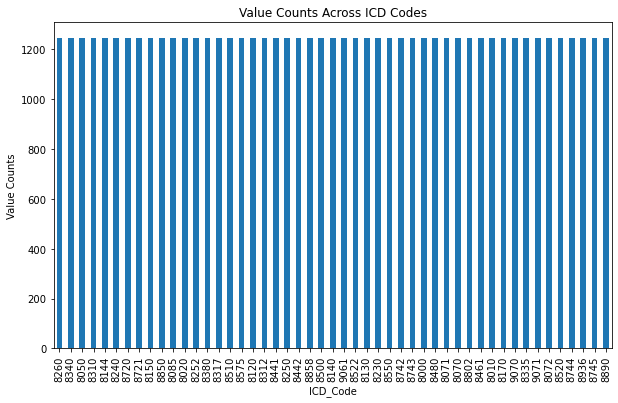

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
df_upsampled['Code'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel("ICD_Code")
ax.set_ylabel("Value Counts")
ax.set_title("Value Counts Across ICD Codes");

In [33]:
'''
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
'''

"\n#Load the pretrained bert model\nmodel_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')\n\n# Load pretrained model/tokenizer\ntokenizer = tokenizer_class.from_pretrained(pretrained_weights)\nmodel = model_class.from_pretrained(pretrained_weights)\n"

In [34]:
#df_upsampled.iloc[1392]

In [35]:
tokenized = df_upsampled["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [36]:
tokenized.iloc[1392]

[101, 13866, 13656, 2062, 2084, 4642, 1999, 4602, 9812, 102]

In [37]:
#pad everything to the same size! Set to the length of the largest input
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [38]:
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(61054, 32)

In [47]:
input_ids[234]

tensor([  101,  1043,  2092,  4305, 12494,  4765, 15070, 11265, 10976, 10497,
        10085, 11467, 13656,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], dtype=torch.int32)

In [48]:
input_ids = torch.tensor(padded)

In [49]:
#input_ids is the embedding of the sentence
print(len(input_ids))
print(len(df_upsampled))

61054
61054


In [50]:
index = 1
print(input_ids[index])
print(df_upsampled["Dx"][index])

tensor([  101, 17503,  2482, 21081,  2863,  1997,  2053,  2569,  2828, 23245,
         2389,  2025,  4728,  9675,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=torch.int32)
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
                           ...                        
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
1    serous borderline tumor atypical proliferative...
Name: Dx, Length: 128, dtype: object


In [51]:
### Have to encode 0-9 each of the ICD Codes: 

In [52]:
#vectorize the Y keys to corresponding values:
y_train = df_upsampled["Code"].values
y_train = np.vectorize(icd_codes_d.get)(y_train)
y_train

array([18, 18, 18, ..., 41, 41, 41])

In [53]:
# train, dev, test: 

In [54]:
# train-test split:
test_size = int(np.floor(len(y_train)*.25))
rand_test_ints = np.random.randint(low=0, high=len(y_train), size=test_size)

y_dev = y_train[rand_test_ints]
y_train = np.delete(y_train, rand_test_ints, axis=0)

x_dev = input_ids[rand_test_ints]
x_train = np.delete(input_ids, rand_test_ints, axis=0)

In [55]:
x_train.shape, y_train.shape

(torch.Size([47595, 32]), (47595,))

In [56]:
y_train.shape, y_dev.shape

((47595,), (15263,))

In [127]:
print(x_train)
print(x_dev)

tensor([[  101, 17503,  2482,  ...,     0,     0,     0],
        [  101, 17503,  2482,  ...,     0,     0,     0],
        [  101, 17503,  2482,  ...,     0,     0,     0],
        ...,
        [  101, 10930, 13687,  ...,     0,     0,     0],
        [  101, 10930, 13687,  ...,     0,     0,     0],
        [  101,  2061, 12644,  ...,     0,     0,     0]], dtype=torch.int32)
tensor([[  101,  5490,  6692,  ...,     0,     0,     0],
        [  101,  6151, 13355,  ...,     0,     0,     0],
        [  101,  2002,  4502,  ...,     0,     0,     0],
        ...,
        [  101, 26947, 16940,  ...,     0,     0,     0],
        [  101, 17503,  8840,  ...,     0,     0,     0],
        [  101,  2152,  3694,  ...,     0,     0,     0]], dtype=torch.int32)


# Classifying

In [221]:
x_train_min, x_train_max = x_train.min(), x_train.max()
new_min, new_max = 0, 1

In [222]:
x_train_new = (x_train - x_train_min)/(x_train_max - x_train_min)*(new_max - new_min) + new_min

In [223]:
print(x_train_new)

tensor([[0.0034, 0.5911, 0.0838,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.5911, 0.0838,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.5911, 0.0838,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0034, 0.3691, 0.4622,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.3691, 0.4622,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.0696, 0.4270,  ..., 0.0000, 0.0000, 0.0000]])


In [224]:
x_dev_min, x_dev_max = x_dev.min(), x_dev.max()
new_min, new_max = 0, 1
x_dev_new = (x_dev - x_dev_min)/(x_dev_max - x_dev_min)*(new_max - new_min) + new_min
print(x_dev_new)

tensor([[0.0034, 0.1854, 0.2260,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.2077, 0.4510,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.0676, 0.1520,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0034, 0.9101, 0.5721,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.5911, 0.2985,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.0727, 0.1248,  ..., 0.0000, 0.0000, 0.0000]])


In [225]:
print(y_train[2243])

29


In [249]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 200
        hidden_2 = 100
        self.fc1 = nn.Linear(32, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 50)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        #x = x.view(-1, 300)
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)
        x = F.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()

optimizer =  torch.optim.SGD(model.parameters(), lr=0.1)
n_epochs = 300

valid_loss_min = np.Inf # set initial "min" to infinity

#data = torch.Tensor(binaryTrainSet["W2V"])
#target = torch.Tensor(binaryTrainSet["sentiment"].astype(int))
#target = target.type(torch.LongTensor)

data = x_train.type(torch.LongTensor)
target = torch.Tensor(y_train)
target = target.type(torch.LongTensor)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train() # prep model for training
    optimizer.zero_grad()
    output = model(data.float())
    #output = output.type(torch.LongTensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)
        
    model.eval() # prep model for evaluation
    output = model(data.float())
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(data)
    valid_loss = valid_loss/len(data)
    
    if epoch % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
    
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 	Training Loss: 3.932424 	Validation Loss: 3.839116
Epoch: 11 	Training Loss: 3.405326 	Validation Loss: 3.277974
Epoch: 21 	Training Loss: 2.931941 	Validation Loss: 2.774156
Epoch: 31 	Training Loss: 2.519391 	Validation Loss: 2.340442
Epoch: 41 	Training Loss: 2.171152 	Validation Loss: 1.981102
Epoch: 51 	Training Loss: 1.884058 	Validation Loss: 1.689255
Epoch: 61 	Training Loss: 1.647837 	Validation Loss: 1.453737
Epoch: 71 	Training Loss: 1.457565 	Validation Loss: 1.262982
Epoch: 81 	Training Loss: 1.300345 	Validation Loss: 1.107306
Epoch: 91 	Training Loss: 1.167340 	Validation Loss: 0.979279
Epoch: 101 	Training Loss: 1.056738 	Validation Loss: 0.873340
Epoch: 111 	Training Loss: 0.967240 	Validation Loss: 0.785135
Epoch: 121 	Training Loss: 0.888168 	Validation Loss: 0.711252
Epoch: 131 	Training Loss: 0.821056 	Validation Loss: 0.648999
Epoch: 141 	Training Loss: 0.763151 	Validation Loss: 0.596192
Epoch: 151 	Training Loss: 0.715479 	Validation Loss: 0.551019
Epo

In [252]:
model.load_state_dict(torch.load('model.pt'))
#testdata = x_dev_new
print(testdata)
outputs = model(testdata.float())
_, predicted = torch.max(outputs.data, 1) 
predictions = np.array(predicted)

print(predictions[8])

tensor([[0.0034, 0.1854, 0.2260,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.2077, 0.4510,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.0676, 0.1520,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0034, 0.9101, 0.5721,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.5911, 0.2985,  ..., 0.0000, 0.0000, 0.0000],
        [0.0034, 0.0727, 0.1248,  ..., 0.0000, 0.0000, 0.0000]])
13


In [251]:
c = 0
accurate = 0
for i in y_dev:
    if i == predictions[c]:
        accurate += 1
    c += 1

print(accurate/c)

0.44892878202188297
